In [0]:
# Data download and unzipping
#!wget https://raw.githubusercontent.com/AakashSudhakar/2018-data-science-bowl/master/compressed_files/stage1_test.zip -c
#!wget https://raw.githubusercontent.com/AakashSudhakar/2018-data-science-bowl/master/compressed_files/stage1_train.zip -c

#!mkdir stage1_train stage1_test

#!unzip stage1_train.zip -d stage1_train/
#!unzip stage1_test.zip -d stage1_test/

# https://github.com/kamalkraj/DATA-SCIENCE-BOWL-2018/tree/master/data

In [0]:
# Downloading and intstalling keras
#!pip install keras

In [1]:
import os
import random
import sys
import warnings
import numpy as np
import pandas as pd
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.utils import Progbar

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose,Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import backend as K

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

# Setting seed for reproducability
seed = 42
random.seed = seed
np.random.seed = seed
smooth = 1.
epochs = 50

C:\Users\E75849\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# Data Path
TRAIN_PATH = 'C:/Users\E75849\Downloads/DATA-SCIENCE-BOWL-2018-master/DATA-SCIENCE-BOWL-2018-master/data/stage1_train/'
TEST_PATH = 'C:/Users/E75849/Downloads/DATA-SCIENCE-BOWL-2018-master/DATA-SCIENCE-BOWL-2018-master/data/stage1_test/'

In [4]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [5]:
# Function read train images and mask return as nump array
def read_train_data(IMG_WIDTH=256,IMG_HEIGHT=256,IMG_CHANNELS=3):
    X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    print('Getting and resizing train images and masks ... ')
    sys.stdout.flush()
    if os.path.isfile("train_img.npy") and os.path.isfile("train_mask.npy"):
        print("Train file loaded from memory")
        X_train = np.load("train_img.npy")
        Y_train = np.load("train_mask.npy")
        return X_train,Y_train
    a = Progbar(len(train_ids))
    for n, id_ in enumerate(train_ids):
        path = TRAIN_PATH + id_
        img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_train[n] = img
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        for mask_file in next(os.walk(path + '/masks/'))[2]:
            mask_ = imread(path + '/masks/' + mask_file)
            mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                        preserve_range=True), axis=-1)
            mask = np.maximum(mask, mask_)
        Y_train[n] = mask
        a.update(n)
    np.save("train_img",X_train)
    np.save("train_mask",Y_train)
    return X_train,Y_train

In [6]:
# Function to read test images and return as numpy array
def read_test_data(IMG_WIDTH=256,IMG_HEIGHT=256,IMG_CHANNELS=3):
    X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    sizes_test = []
    print('\nGetting and resizing test images ... ')
    sys.stdout.flush()
    if os.path.isfile("test_img.npy") and os.path.isfile("test_size.npy"):
        print("Test file loaded from memory")
        X_test = np.load("test_img.npy")
        sizes_test = np.load("test_size.npy")
        return X_test,sizes_test
    b = Progbar(len(test_ids))
    for n, id_ in enumerate(test_ids):
        path = TEST_PATH + id_
        img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
        sizes_test.append([img.shape[0], img.shape[1]])
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_test[n] = img
        b.update(n)
    np.save("test_img",X_test)
    np.save("test_size",sizes_test)
    return X_test,sizes_test

In [7]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [8]:
# Iterate over the test IDs and generate run-length encodings for each seperate mask identified by skimage
def mask_to_rle(preds_test_upsampled):
    new_test_ids = []
    rles = []
    for n, id_ in enumerate(test_ids):
        rle = list(prob_to_rles(preds_test_upsampled[n]))
        rles.extend(rle)
        new_test_ids.extend([id_] * len(rle))
    return new_test_ids,rles

In [9]:
# Metric function
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Loss funtion
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [10]:
def get_unet(IMG_WIDTH=256,IMG_HEIGHT=256,IMG_CHANNELS=3):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255) (inputs)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam',loss='binary_crossentropy', metrics=[dice_coef])
    return model

In [11]:
# get train_data
train_img,train_mask = read_train_data()

# get test_data
test_img,test_img_sizes = read_test_data()

Getting and resizing train images and masks ... 
669/670 [============================>.] - ETA: 0s
Getting and resizing test images ... 
63/65 [============================>.] - ETA: 0s

In [15]:
from keras import backend as K
K.set_image_dim_ordering('tf')

In [16]:
# get u_net model
u_net = get_unet()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [19]:
u_net.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 256, 256, 3)   0                                            
____________________________________________________________________________________________________
lambda_3 (Lambda)                (None, 256, 256, 3)   0           input_3[0][0]                    
____________________________________________________________________________________________________
conv2d_9 (Conv2D)                (None, 256, 256, 16)  448         lambda_3[0][0]                   
____________________________________________________________________________________________________
dropout_5 (Dropout)              (None, 256, 256, 16)  0           conv2d_9[0][0]                   
___________________________________________________________________________________________

In [18]:
# fit model on train_data
print("\nTraining...")
u_net.fit(train_img,train_mask,batch_size=4,epochs=epochs)


Training...
Epoch 1/50
670/670 [==============================] - 64s - loss: 0.2495 - dice_coef: 0.5246    
Epoch 2/50
670/670 [==============================] - 58s - loss: 0.1190 - dice_coef: 0.7739    
Epoch 3/50
670/670 [==============================] - 58s - loss: 0.0998 - dice_coef: 0.8058    
Epoch 4/50
670/670 [==============================] - 57s - loss: 0.1010 - dice_coef: 0.8106    
Epoch 5/50
670/670 [==============================] - 58s - loss: 0.1073 - dice_coef: 0.7885    
Epoch 6/50
670/670 [==============================] - 59s - loss: 0.1007 - dice_coef: 0.8068    
Epoch 7/50
670/670 [==============================] - 58s - loss: 0.0904 - dice_coef: 0.8243    
Epoch 8/50
670/670 [==============================] - 57s - loss: 0.0898 - dice_coef: 0.8303    
Epoch 9/50
670/670 [==============================] - 57s - loss: 0.0891 - dice_coef: 0.8295    
Epoch 10/50
670/670 [==============================] - 57s - loss: 0.0841 - dice_coef: 0.8366    
Epoch 11/50
670/

In [20]:
print("Predicting")
# Predict on test data
test_mask = u_net.predict(test_img,verbose=1)

Predicting
65/65 [==============================] - 5s     


In [21]:
# Create list of upsampled test masks
test_mask_upsampled = []
for i in range(len(test_mask)):
    test_mask_upsampled.append(resize(np.squeeze(test_mask[i]),
                                       (test_img_sizes[i][0],test_img_sizes[i][1]), 
                                       mode='constant', preserve_range=True))


In [22]:
test_ids,rles = mask_to_rle(test_mask_upsampled)

In [25]:
test_mask.shape

(65, 256, 256, 1)

In [30]:
def plot_sample(test_img, test_mask, ix=None):
    if ix is None:
        ix = random.randint(0, len(test_img))

    has_mask = test_mask[ix].max() > 0

    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    ax[0].imshow(test_img[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(test_mask[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Original')

    ax[1].imshow(test_mask[ix].squeeze())
    ax[1].set_title('Segmented');

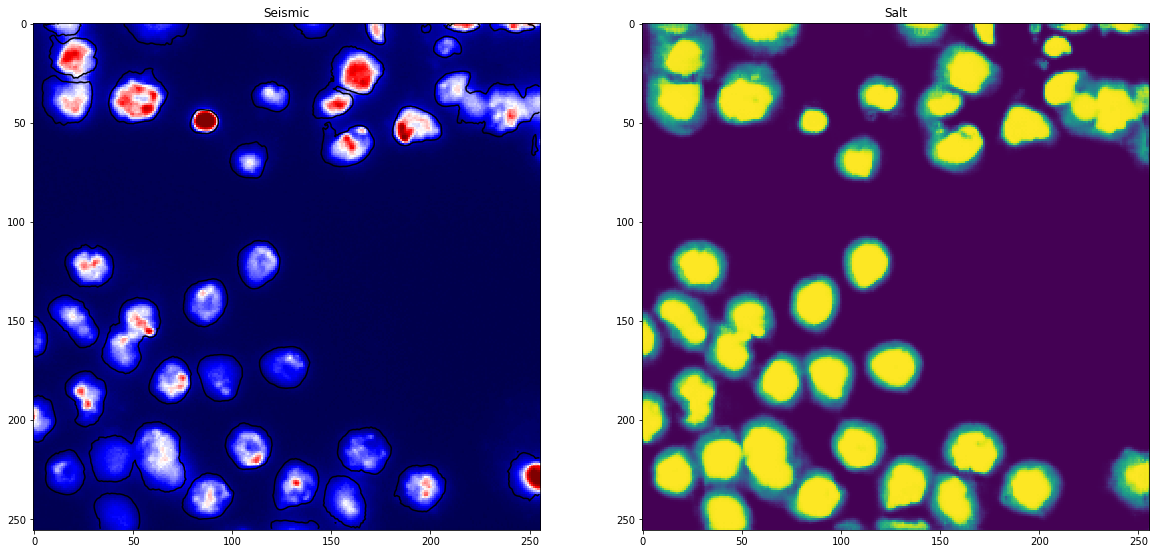

In [29]:
# Check if training data looks all right
import matplotlib.pyplot as plt
plot_sample(test_img, test_mask, ix=2)

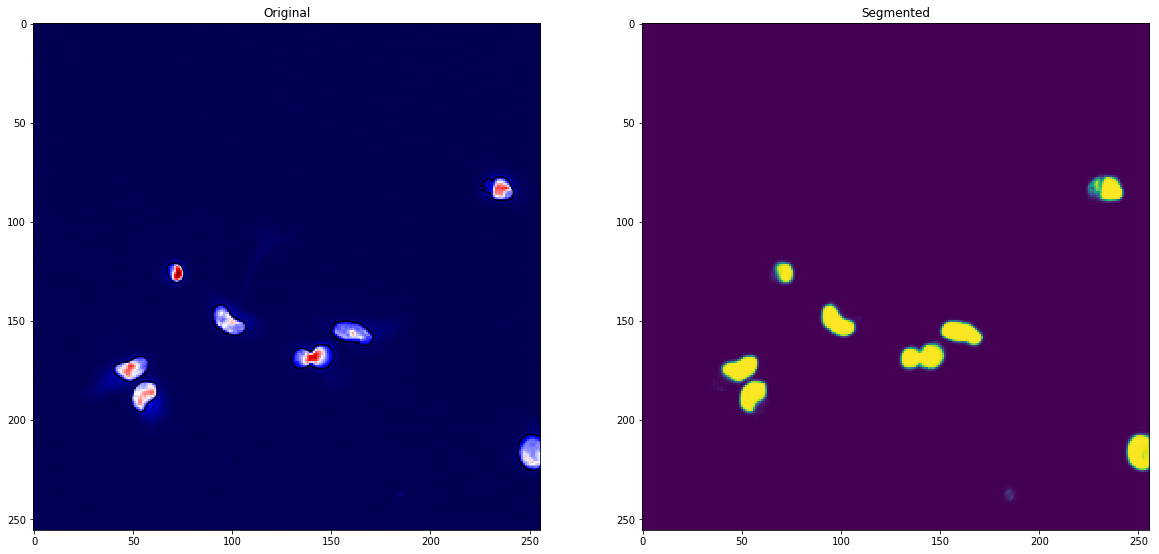

In [31]:
# Check if training data looks all right
import matplotlib.pyplot as plt
plot_sample(test_img, test_mask, ix=15)

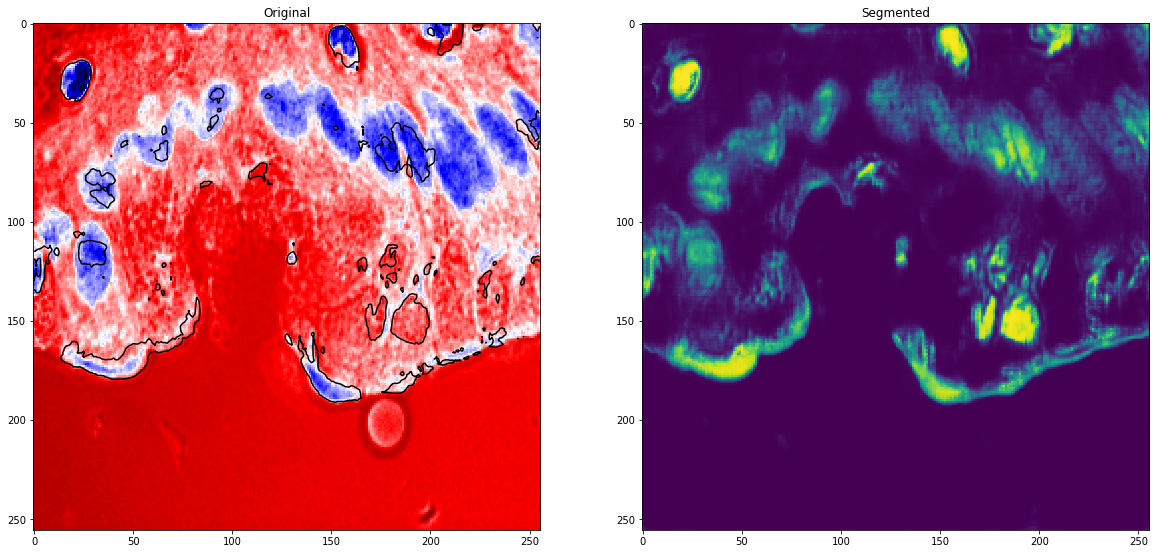

In [33]:
# Check if training data looks all right
import matplotlib.pyplot as plt
plot_sample(test_img, test_mask, ix=14)

In [0]:
# Code to download files from Google colab

#from google.colab import files

#files.download('sub-dsbowl2018.csv')